<a href="https://www.kaggle.com/code/milhamwahyudi/cnn-tire-texture-classification?scriptVersionId=97306779" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **INCLUDE LIBRARY**

import several necessary libraries to work with the data before doing analysis and modeling

In [1]:
#Analysis
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#NN Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# **AUGMENTATION**

We apply on-the-fly data augmentation, a technique to expand the training dataset size by creating a modified version of the original image which can improve model performance and the ability to generalize. We will use with the following parameters:

- `rotation_range`: Degree range for random rotations. We choose 360 degrees since the product is a round object.
- `width_shift_range`: Fraction range of the total width to be shifted.
- `height_shift_range`: Fraction range of the total height to be shifted.
- `shear_range`: Degree range for random shear in a counter-clockwise direction.
- `zoom_range`: Fraction range for random zoom.
- `horizontal_flip` and `vertical_flip` are set to True for randomly flip image horizontally and vertically.
- `brightness_range`: Fraction range for picking a brightness shift value.

Other parameters:

- `rescale`: Eescale the pixel values to be in range 0 and 1.
- `validation_split`: Reserve 20% of the training data for validation, and the rest 80% for model fitting.

In [2]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

# **DATASET PREPARATION**

Here is the structure of our folder containing image data:


```
Tire Texture
├───testing_data
│   ├───cracked
│   └───normal
└───training_data
    ├───cracked
    └───normal
```

The folder `Tire Texture` consists of two subfolders `testing_data` and `training_data` in which each of them has another subfolder: `cracked` and `normal` denoting the class of our target variable. The images inside `training_data` will be used for model fitting and validation, while `testing_data` will be used purely for testing the model performance on unseen images.

We define another set of value for the `flow_from_directory` parameters:

- `IMAGE_DIR`: The directory where the image data is stored.
- `IMAGE_SIZE`: The dimension of the image (379 px by 379 px).
- `BATCH_SIZE`: Number of images that will be loaded and trained at one time.
- `SEED_NUMBER`: Ensure reproducibility.
- `color_mode = "grayscale"`: Treat our image with only one channel color.
- `class_mode` and `classes` define the target class of our problem. In this case, we denote the `cracked` class as positive (1), and `normal` as a negative class.
- `shuffle` = True to make sure the model learns the defect and ok images alternately.

In [3]:
IMAGE_DIR = "../input/tire-texture-image-recognition/Tire Textures/"

IMAGE_SIZE = (379, 379)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"normal": 0, "cracked": 1},
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",
                                        subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "training_data",
                                        subset = "validation", shuffle = True, **gen_args)


Found 563 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [4]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "testing_data",
                                                  shuffle = False,
                                                  **gen_args)

Found 325 images belonging to 2 classes.


**IMAGE VISUALIZATION**

We successfully load and apply on-the-fly data augmentation according to the specified parameters. Now, in this section, we visualize the image to make sure that it is loaded correctly.

In [5]:
mapping_class = {0: "normal", 1: "cracked"}
mapping_class

{0: 'normal', 1: 'cracked'}

In [6]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

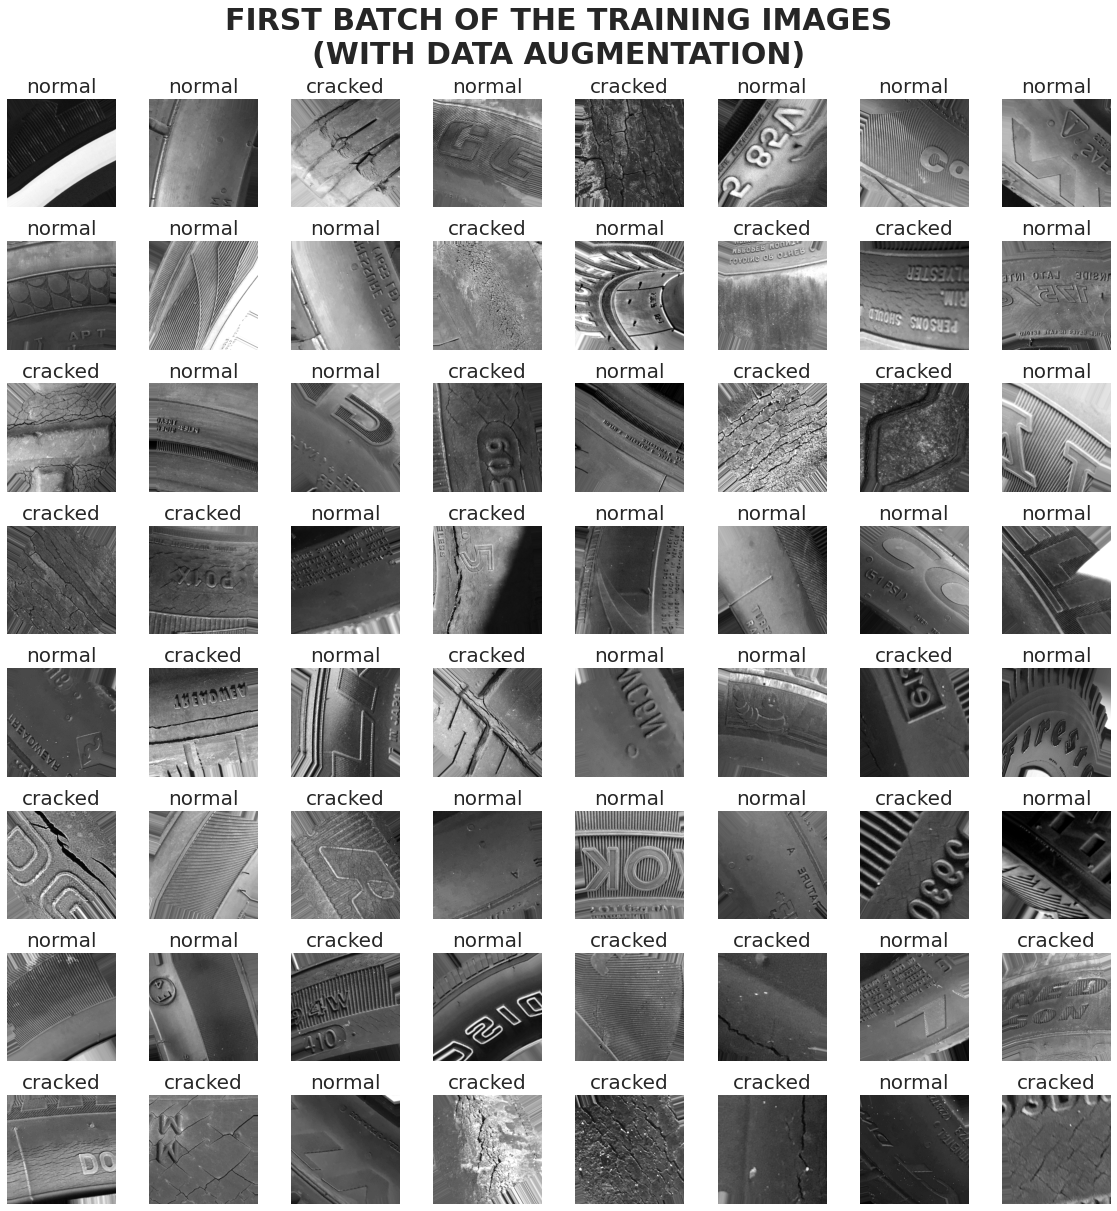

In [7]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

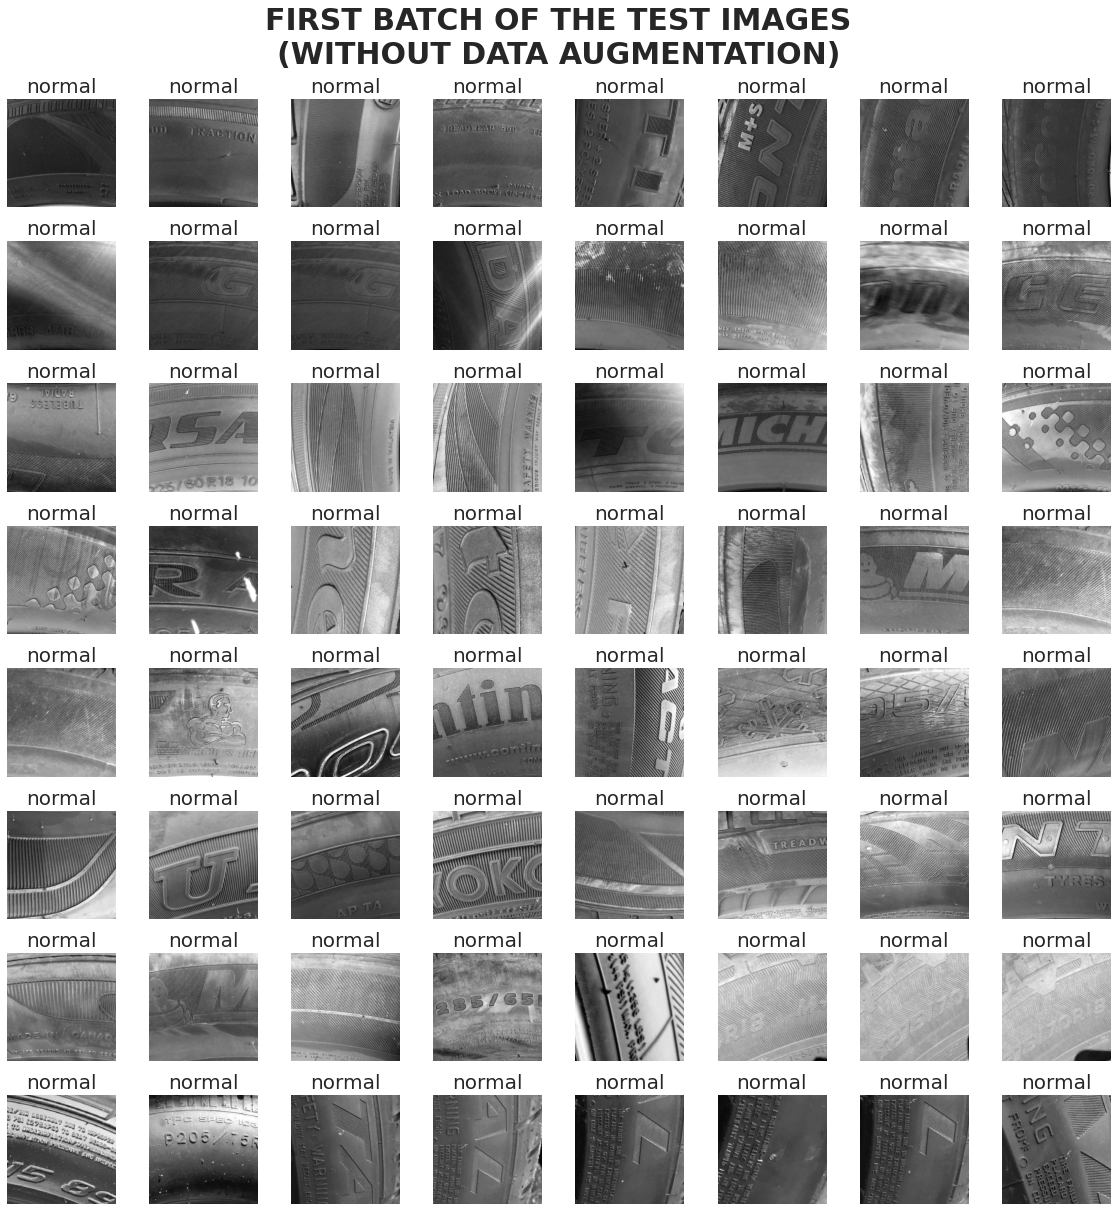

In [8]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

# **BUILDING MODEL**
As mentioned earlier, we are going to train a CNN model to classify the casting product image. CNN is used as an automatic feature extractor from the images so that it can learn how to distinguish between `defect` and `ok` casted products. It effectively uses the adjacent pixel to downsample the image and then use a prediction (fully-connected) layer to solve the classification problem. This is a simple illustration by [Udacity](https://github.com/udacity/deep-learning-v2-pytorch) on how the layers are arranged sequentially:

![](https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/CNN_all_layers.png)

### Define Architecture

Here is the detailed architecture that we are going to use:

1. **First convolutional layer**: consists of 128 filters with kernel_size matrix 3 by 3. Using 2-pixel strides at a time, reduce the image size by half.
2. **First pooling layer**: Using max-pooling matrix 2 by 2 (pool_size) and 2-pixel strides at a time further reduce the image size by half.
3. **Second convolutional layer**: Just like the first convolutional layer but with 64 filters only.
4. **Second pooling layer**: Same as the first pooling layer.
5. **Third convolutional layer**: Just like the first and second layer but with 32 filters only.
6. **Third pooling layer**: Same as previous pooling layers
7. **Forth convolutional layer**: Jusdt like previous layer but with 16 filters only.
8. **Forth pooling layer**: Same as previous pooling layers
9. **Flattening**: Convert two-dimensional pixel values into one dimension, so that it is ready to be fed into the fully-connected layer.
10. **First dense layer + Dropout**: consists of 128 units and 1 bias unit. Dropout of rate 20% is used to prevent overfitting.
11. **Second dense layer + Dropout**: consists of 64 units and 1 bias unit. Dropout of rate 20% is also used to prevent overfitting.
12. **Output layer**: consists of only one unit and activation is a sigmoid function to convert the scores into a probability of an image being defect.

For every layer except output layer, we use Rectified Linear Unit (ReLU) activation function.

![relu](https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/relu_ex.png)


In [9]:
model_cnn = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 128,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 64,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Third convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Third pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Forth convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Forth pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 189, 189, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 16)          4

2022-06-02 12:34:52.581084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Compile the Model

Next, we specify how the model backpropagates or update the weights after each batch feed-forward. We use `adam` optimizer and a loss function `binary cross-entropy` since we are dealing with binary classification problem. The metrics used to monitor the training progress is accuracy.

In [10]:
model_cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Model Fitting
Before we do model fitting, let's check whether GPU is available or not.

In [11]:
checkpoint = ModelCheckpoint('model/cnn_tire_texture_model.hdf5',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

model_cnn.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size = 16,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1)

2022-06-02 12:35:11.174698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
9/9 [==============================] - 66s 7s/step - loss: 0.6928 - accuracy: 0.5169 - val_loss: 0.6924 - val_accuracy: 0.5143

Epoch 00001: val_loss improved from inf to 0.69241, saving model to model/cnn_tire_texture_model.hdf5
Epoch 2/20
9/9 [==============================] - 51s 6s/step - loss: 0.6938 - accuracy: 0.4831 - val_loss: 0.6914 - val_accuracy: 0.5357

Epoch 00002: val_loss improved from 0.69241 to 0.69138, saving model to model/cnn_tire_texture_model.hdf5
Epoch 3/20
9/9 [==============================] - 51s 6s/step - loss: 0.6918 - accuracy: 0.5346 - val_loss: 0.6911 - val_accuracy: 0.5357

Epoch 00003: val_loss improved from 0.69138 to 0.69106, saving model to model/cnn_tire_texture_model.hdf5
Epoch 4/20
9/9 [==============================] - 51s 6s/step - loss: 0.6908 - accuracy: 0.5346 - val_loss: 0.6908 - val_accuracy: 0.5357

Epoch 00004: val_loss improved from 0.69106 to 0.69085, saving model to model/cnn_tire_texture_model.hdf5
Epoch 5/20
9/9 [========

### Training Evaluation
Let's plot both loss and accuracy metrics for train and validation data based on each epoch.

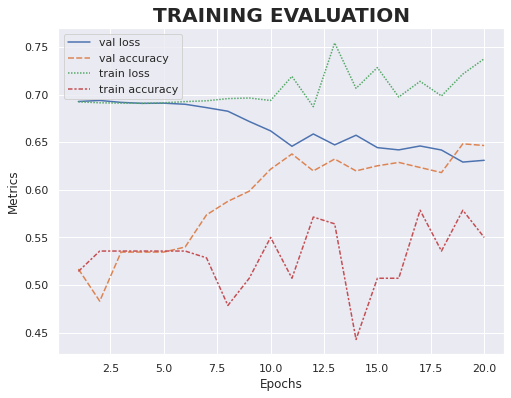

In [12]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_cnn.history.history,
                                 index = range(1, 1+len(model_cnn.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

We can conclude that the model is **not overfitting** the data since both train loss and val loss simultaneously dropped towards zero. Also, both train accuracy and val accuracy increase towards 100%.

### Testing on Unseen Images

Our model performs very well on the training and validation dataset which uses augmented images. Now, we test our model performance with unseen and unaugmented images.

In [13]:
best_model = load_model("model/cnn_tire_texture_model.hdf5")

In [14]:
y_pred_prob = best_model.predict(test_dataset)

The output of the prediction is in the form of probability. We use THRESHOLD = 0.5 to separate the classes. If the probability is greater or equal to the THRESHOLD, then it will be classified as cracked, otherwise normal.

In [15]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["normal", "cracked"]],
    columns = [["Predicted", "Predicted"], ["normal", "cracked"]],
)

Predicted        
                  normal cracked
Actual normal         60      55
       cracked        80     130

In [16]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.4286    0.5217    0.4706       115
           1     0.7027    0.6190    0.6582       210

    accuracy                         0.5846       325
   macro avg     0.5656    0.5704    0.5644       325
weighted avg     0.6057    0.5846    0.5918       325



According to the problem statement, we want to minimize the case of False Negative, where the defect product is misclassified as `normal`. This can cause the whole order to be rejected and create a big loss for the company. Therefore, in this case, we prioritize Recall over Precision.

But if we take into account the cost of re-casting a product, we have to minimize the case of False Positive also, where the normal product is misclassified as `cracked`. Therefore we can prioritize the `F1 score` which combines both Recall and Precision.

On test dataset, the model achieves not so good result as follow:

- Accuracy: 55.84%
- Recall: 61.90%
- Precision: 70.27%
- F1 score: 65.82%

# Conclusion
By using CNN and on-the-fly data augmentation, the performance of our model in training, validation, and test images is not good, reaching 58-65% accuracy and F1 score. We can utilize this model by embedding it into a surveillance camera where the system can automatically separate defective product from the production line. This method surely can reduce human error and human resources on manual inspection, but it still needs supervision from human since the model is not 100% correct at all times.